# NOTE: This notebook was for dev purposes only.  Not guaranteed to run anymore (and run order is somewhat nonlinear). All relevant code as been moved to the infonet package or in an experiment

In [1]:
import numpy as np
import numpy.random as npr
import json
import io
import time
import os.path
import six
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()
plt.rcParams['figure.figsize'] = (6,4)

import chainer as ch
import chainer.training.extensions # for some reason this isn't automatically imported

In [2]:
data = json.loads(io.open('../data/ace_05_head_yaat.json', 'r').read())

In [3]:
from collections import Counter
import numpy as np
import numpy.random as npr

class Vocab():
    """ A convenience vocabulary wrapper 
    
    TODO: Add in sampling table functionality
    """
    def __init__(self, 
                 tokens=None, 
                 min_count=5,
                 pad_token='<PAD>', 
                 unk_token='<UNK>'):
        self.min_count=min_count
        self.pad_token = pad_token
        self.unk_token = unk_token
        
        self.use(tokens)
#         self.make_sampling_table()

    @property
    def n(self):
        """ The total number of tokens seen by the vocabulary.
        
        This **does not** include tokens which have not been seen `min_count` times
        """
        return self._n

    @property
    def v(self):
        """ The total number of unique tokens in the vocabulary.
        
        This **does not** include tokens which have not been seen `min_count` times
        """
        return self._v

    @property
    def pad(self):
        """ Return the PAD token """
        return self.pad_token

    @property
    def ipad(self):
        """ Return the index of the PAD token """
        return self.idx(self.pad_token)
    
    @property
    def unk(self):
        """ Return the UNK token """
        return self.unk_token

    @property
    def iunk(self):
        """ Return the index of the UNK token """
        return self.idx(self.unk_token)

    def idx(self, token):
        """ Return the index of a token or the index of UNK if not in vocab.
        
        Additionally this will return UNK if the token is in the vocab 
        but has yet to be seen `min_count` times
        """
        if token == self.pad_token:
            return self._vocab2idx[token]
        elif token in self.vocabset:
            if self.count_index[token] >= self.min_count:
                return self._vocab2idx[token]
            else:
                return self._vocab2idx[self.unk_token]
        else:
            return self._vocab2idx[self.unk_token]

    def token(self, idx):
        """ Return the token corresponding to the input index `idx`.
        
        If the index is not in the vocabulary, or it is the index
        of a token that has not been seen `min_count` times,
        the UNK token is returned instead
        """
        if idx in self.idxset:
            token = self._idx2vocab[idx]
            if self.count_index[token] >= self.min_count:
                return token
            else:
                return self.unk_token
        else:
            return self.unk_token

    def use(self, tokens):
        """ Create the vocabulary, using these tokens.
        
        This method will reset the vocab with these tokens.
        
        `tokens` is expected to be a flat list.
        """
        self.count_index = Counter()
        self._vocab2idx = {self.pad_token:0,
                           self.unk_token:1}
        self._idx2vocab = {0:self.pad_token,
                           1:self.unk_token}
        if tokens:
            self.add(tokens)

    def add(self, tokens):
        """ Add these tokens to the vocabulary.
        
        This can be used iteratively, adding, say, one sentence at a time.
        
        NOTE: Expects `tokens` to be a flat list.
        """
        # increment counts of tokens seen here
        for token in tokens:
            self.count_index[token] += 1
        
        # add tokens to the vocabulary if they are new
        token_set = set(tokens)
        for token in token_set:
            if token not in self._vocab2idx:
                new_idx = len(self._vocab2idx)
                self._vocab2idx[token] = new_idx
                self._idx2vocab[new_idx] = token
        
        # now precompute commonly used properties of the vocab (ignoring infrequent tokens)
        self.vocabset = set([ token for (token, count) in self.count_index.most_common()
                              if count >= self.min_count ]) 
        self.vocabset |= set([self.pad_token, self.unk_token])
        self.idxset = set([ self._vocab2idx[token] for token in self.vocabset ])
        self._n = sum( count for count in self.count_index.values() if count >= self.min_count )
        self._v = sum( 1 for count in self.count_index.values() if count >= self.min_count ) + 2 # <PAD> and <UNK>
        
    def drop_infrequent(self):
        """ Drop all words from the vocabulary that have not been seen `min_count` times
        and recompute the vocabulary indices.
        
        This is useful for when the vocab has a long tail of infrequent words
        that we no longer wish to account for.
        
        NOTE: This changes indices of tokens in the vocab!
        """
        # remove all infrequent tokens from the count index
        to_remove = set(self.count_index.keys()) - self.vocabset
        for token in to_remove:
            self.count_index.pop(token)
            
        # now reset the vocab dicts and reindex the tokens
        self._vocab2idx = {self.pad_token:0,
                           self.unk_token:1}
        self._idx2vocab = {0:self.pad_token,
                           1:self.unk_token}
        for token in self.count_index.keys():
            new_idx = len(self._vocab2idx)
            self._vocab2idx[token] = new_idx
            self._idx2vocab[new_idx] = token
            
        # precompute commonly used properties of the vocab
        self.vocabset = set(self._vocab2idx.keys())
        self.idxset = set(self._idx2vocab.keys())
        self._n = sum( count for count in self.count_index.values() )
        self._v = len(self._vocab2idx)

    def count(self, token):
        """ Get the count of a token.  
        
        This includes tokens with countes below `min_count`,
        which have been seen but are not included in the vocab.
        """
        return self.count_index[token]

#     def make_sampling_table(self, power_scalar=.75):
#         # from 0 to V-1, get the frequency
#         self.vocab_distribution = np.array([ (self.count_index[self._idx2vocab[idx]]/float(self._n))**power_scalar
#                                     for idx in range(len(self.idxset))])
#         self.vocab_distribution /= np.sum(self.vocab_distribution).astype(np.float)

#     def sample(self, sample_shape):
#         # sample a tensor of indices
#         # by walking up the CDF
#         # setting each position to the index
#         # of the word which is the closest
#         # word with that CDF
#         sums = np.zeros(sample_shape)
#         rands = npr.uniform(size=sample_shape)
#         idxs = np.zeros(sample_shape)
#         for i in range(len(self.vocab_distribution)):
#             sums += self.vocab_distribution[i]
#             idxs[sums <= rands] = i
#         return idxs.astype(np.int)

In [4]:
def Entity_BIO_map(mention_labels, annotation):
    """ Uses BIO scheme (untyped) for entities only """
    if annotation['node-type'] == 'entity':
        left, right = tuple(annotation['ann-span'])
        mention_labels[left] = 'B'
        for i in range(1, right-left+1):
            mention_labels[left+i] = 'I'
    return mention_labels

def Entity_typed_BIO_map(mention_labels, annotation):
    """ Uses BIO scheme (typed) for entities only """
    if annotation['node-type'] == 'entity':
        mention_type = annotation['type']
        left, right = tuple(annotation['ann-span'])
        mention_labels[left] = 'B-'+mention_type
        for i in range(1, right-left+1):
            mention_labels[left+i] = 'I-'+mention_type
    return mention_labels

def Entity_BILOU_map(mention_labels, annotation):
    """ Uses BILOU scheme (untyped) for entities only """
    if annotation['node-type'] == 'entity':
        left, right = tuple(annotation['ann-span'])
        if left == right:
            mention_labels[left] = 'U'
        else:
            mention_labels[left] = 'B'
            for i in range(1, right-left):
                mention_labels[left+i] = 'I'
            mention_labels[right] = 'L'
    return mention_labels

def Entity_typed_BILOU_map(mention_labels, annotation):
    """ Uses BILOU scheme (typed) for entities only """
    if annotation['node-type'] == 'entity':
        mention_type = annotation['type']
        left, right = tuple(annotation['ann-span'])
        if left == right:
            mention_labels[left] = 'U-'+mention_type
        else:
            mention_labels[left] = 'B-'+mention_type
            for i in range(1, right-left):
                mention_labels[left+i] = 'I-'+mention_type
            mention_labels[right] = 'L-'+mention_type
    return mention_labels

def compute_flat_mention_labels(doc, scheme_func=Entity_BIO_map):
    """ Takes a YAAT style document and computes token-level mention label list.
    
    This function only considers the outermost spans (as per ACE evaluation)
    by editing the mentions of shortest span-length to longest.
    Thus wider mentions will override narrower nested mentions.
    
    Example:
    --------
    
    tokens: ['part', 'of' , 'mention', '.', 'not', 'part']
    with annotation: {'ann-type':'node',
                      'node-type':'entity',
                      'ann-span':[0,2]}
    with scheme: BIO
    
    yields:
    mention_labels = ['B', 'I', 'I', 'O', 'O', 'O']
    """
    mention_labels = ['O' for token in doc['tokens']]
    mentions = [ annotation for annotation in doc['annotations'] if annotation['ann-type'] == 'node' ]
    for annotation in sorted(mentions, key=lambda x:x['ann-span'][1]-x['ann-span'][0]):
        mention_labels = scheme_func(mention_labels, annotation)
    return mention_labels

In [5]:
token_vocab = Vocab(min_count=5)
for doc in data.values():
    token_vocab.add(doc['tokens'])
print '{} total tokens and {} types with mincount > 5'.format(token_vocab.n, token_vocab.v)

324491 total tokens and 4826 types with mincount > 5


In [6]:
doc['boundary_labels'] = compute_flat_mention_labels(doc, Entity_BIO_map)
for token, label in zip(doc['tokens'], doc['boundary_labels'])[100:110]:
    print token, label

of O
al B
qaeda I
. O
they O
may O
have O
been O
timed O
to O


In [7]:
boundary_vocab = Vocab(min_count=0)
for doc in data.values():
    doc['boundary_labels'] = compute_flat_mention_labels(doc, Entity_BIO_map)
    boundary_vocab.add(doc['boundary_labels'])

In [8]:
xy = [(doc['tokens'], doc['boundary_labels']) for doc in data.values()]
npr.shuffle(xy)

valid_split = int(len(xy)*.6)
test_split = int(len(xy)*.8)
xy_train, xy_valid, xy_test = xy[:valid_split], xy[valid_split:test_split], xy[test_split:]

x_train = [d[0] for d in xy_train]
y_train = [d[1] for d in xy_train]
x_valid = [d[0] for d in xy_valid]
y_valid = [d[1] for d in xy_valid]
x_test = [d[0] for d in xy_test]
y_test = [d[1] for d in xy_test]

print '{} train, {} validation, and {} test documents'.format(len(x_train), len(x_valid), len(x_test))

321 train, 53 validation, and 161 test documents


In [9]:
# # create an additional training set that is split on sentences
# def split_sentences(doc_x, doc_y):
#     xs, ys = [], []
#     sent_x, sent_y = [], []
#     for x, y in zip(doc_x, doc_y):
#         if x == '.':
#             sent_x.append(x)
#             sent_y.append(y)
#             xs.append(sent_x)
#             ys.append(sent_y)
#             sent_x = []
#             sent_y = []
#         else:
#             sent_x.append(x)
#             sent_y.append(y)
#     return xs, ys

# def split_all_docs(xs, ys):
#     all_xs, all_ys = [], []
#     for x,y in zip(xs, ys):
#         sent_xs, sent_ys = split_sentences(x, y)
#         all_xs.extend(sent_xs)
#         all_ys.extend(sent_ys)
#     return all_xs, all_ys

# x_sent_train, y_sent_train = split_all_docs(x_train, y_train)
# x_sent_test, y_sent_test = split_all_docs(x_test, y_test)

In [10]:
# before we do conversions, we need to drop unfrequent words from the vocab and reindex it
token_vocab.drop_infrequent()
boundary_vocab.drop_infrequent()

In [11]:
def convert_sequence(sequence, conversion_func):
    return [ conversion_func(s) for s in sequence ]

def convert_sequences(sequences, conversion_func):
    return [ convert_sequence(sequence, conversion_func) for sequence in sequences ]

ix_train = convert_sequences(x_train, token_vocab.idx)
ix_valid = convert_sequences(x_valid, token_vocab.idx)
ix_test = convert_sequences(x_test, token_vocab.idx)
iy_train = convert_sequences(y_train, boundary_vocab.idx)
iy_valid = convert_sequences(y_valid, boundary_vocab.idx)
iy_test = convert_sequences(y_test, boundary_vocab.idx)

### A bucketed iterator for the variable length sequence data

In [12]:
class BucketedIterator(ch.dataset.iterator.Iterator):
    def _anchored_permutation(self, order):
        """ Randomized permutation except last element is alway the largest.
        
        Used for bucketed rnn batches where the last batch may 
        (and if so must) be smaller than the rest.
        """
        order = npr.permutation(order)
#         m = np.max(order)
#         order[order==m] = order[-1]
#         order[-1] = m
        return order
        
    def __init__(self, dataset, batch_size, repeat=True, shuffle=True):
        self.dataset = dataset
        self.n = n = len(self.dataset)
        self.batch_size = batch_size
        self._repeat = repeat

        # first decide if dataset is one set of sequences or a zipped set of seequences
        if type(self.dataset[0][0]) not in (tuple, list, dict):
            # one dataset
            self.dataset.sort(key=lambda x:len(x), reverse=True)
        else:
            # zipped or dict dataset
            self.dataset.sort(key=lambda x:len(x[0]), reverse=True)
        # then sort them by length of leading (or only) sequence so they are length bucketed
        # and sorted by length within minibatches (needed for chainer RNNs)
        self.n_batches = n//batch_size if (n % batch_size == 0) else n//batch_size + 1
        self.minibatches = [ tuple(self.dataset[i*batch_size:(i+1)*batch_size])
                              for i in range(self.n_batches) ]

        if shuffle:
            self._order = self._anchored_permutation(len(self.minibatches))
        else:
            self._order = None

        self.current_position = 0
        self.epoch = 0
        self.is_new_epoch = False

    def __next__(self):
        if not self._repeat and self.epoch > 0:
            raise StopIteration

        if self._order is not None:
            i = self._order[self.current_position]
        else:
            i = self.current_position
        minibatch = self.minibatches[i]
        
        # last minibatch in epoch
        if self.current_position == self.n_batches-1:
            self.epoch += 1
            self.is_new_epoch = True
            self.current_position = 0
            if self._order is not None:
                self._order = self._anchored_permutation(self._order)
        else:
            self.is_new_epoch = False
            self.current_position += 1
        return minibatch
    
    @property
    def epoch_detail(self):
        return self.epoch + self.current_position / len(self.dataset)

    def serialize(self, serializer):
        self.current_position = serializer('current_position',
                                           self.current_position)
        self.epoch = serializer('epoch', self.epoch)
        self.is_new_epoch = serializer('is_new_epoch', self.is_new_epoch)
        if self._order is not None:
            serializer('_order', self._order)
            
class SequenceIterator(ch.dataset.iterator.Iterator):
    def __init__(self, dataset, batch_size, repeat=True, shuffle=True):
        self.dataset = dataset
        self.n = n = len(self.dataset)
        self.batch_size = batch_size
        self._repeat = repeat
        self.shuffle = shuffle
        self.n_batches = n//batch_size if (n % batch_size == 0) else n//batch_size + 1

        if shuffle:
            npr.shuffle(self.dataset)

        self.current_position = 0
        self.epoch = 0
        self.is_new_epoch = False

    def __next__(self):
        if not self._repeat and self.epoch > 0:
            raise StopIteration

        i = self.current_position
        minibatch = self.dataset[i*self.batch_size:(i+1)*self.batch_size]
        # minibatches must be sorted by descending sequence len
        # sort key changes if dataset is one set of sequences or a zipped set of seequences
        if type(self.dataset[0][0]) not in (tuple, list, dict):
            # one dataset
            minibatch.sort(key=lambda x:len(x), reverse=True)
        else:
            # zipped or dict dataset
            minibatch.sort(key=lambda x:len(x[0]), reverse=True)
        
        # last minibatch in epoch
        if self.current_position == self.n_batches-1:
            self.epoch += 1
            self.is_new_epoch = True
            self.current_position = 0
            if self.shuffle:
                npr.shuffle(self.dataset)
        else:
            self.is_new_epoch = False
            self.current_position += 1

        return minibatch
    
    @property
    def epoch_detail(self):
        return self.epoch + self.current_position / len(self.dataset)

    def serialize(self, serializer):
        self.current_position = serializer('current_position',
                                           self.current_position)
        self.epoch = serializer('epoch', self.epoch)
        self.is_new_epoch = serializer('is_new_epoch', self.is_new_epoch)
        if self._order is not None:
            serializer('_order', self._order)

In [353]:
class Tagger(ch.Chain):
    def __init__(self, embed, lstm_size, out_size):
        super(Tagger, self).__init__(
            embed = embed,
            lstm = ch.links.LSTM(embed.W.shape[1], lstm_size),
            out = ch.links.Linear(lstm_size, out_size)
        )
    
    def reset_state(self):
        self.lstm.reset_state()
    
    def __call__(self, x_list):
        embeds = [ self.embed(x) for x in x_list ]
        lstms = [ self.lstm(x) for x in embeds ]
        outs = [ self.out(h) for h in lstms ]
        return outs, lstms
    
class TaggerLoss(ch.Chain):
    def __init__(self, tagger, 
                 loss_func=ch.functions.softmax_cross_entropy):
        super(TaggerLoss, self).__init__(
            tagger = tagger
        )
        self.loss_func = loss_func
        
    def __call__(self, x_list, y_list):
        loss = 0
        yhat_list,_ = self.tagger(x_list)
        for yhat, y in zip(yhat_list, y_list):
            loss += self.loss_func(yhat, y)
        return loss
    
class Extractor(ch.Chain):
    def __init__(self, 
                 feature_size,
                 n_mention_class,
                 n_relation_class,
                 in_tags=(1,2), 
                 out_tags=(0,),
                 max_rel_dist=10000):
        super(Extractor, self).__init__(
            f_m=ch.links.Linear(feature_size, n_mention_class),
            f_r=ch.links.Linear(2*feature_size, n_relation_class)
        )
#         self.f_m.W.data = npr.randint((feature_size, n_mention_class))
        self.in_tags = in_tags
        self.out_tags = out_tags
        self.max_rel_dist = max_rel_dist
        
    def _extract_graph(self, tagger_preds, tagger_features):
        # convert from time-major to batch-major
        tagger_preds = ch.functions.transpose_sequence(tagger_preds)
        tagger_features = ch.functions.transpose_sequence(tagger_features)
#         print len(tagger_preds)
        
        # extract the mentions and relations for each doc
        all_boundaries = extract_all_mentions(tagger_preds, 
                                              in_tags=self.in_tags, 
                                              out_tags=self.out_tags)
#         print 'N', [len(b) for b in all_boundaries]
        all_mentions = []
        all_relation_idxs = []
        all_left_mentions = []
        all_right_mentions = []
        for s, (boundaries, seq, features) in enumerate(zip(all_boundaries, tagger_preds, tagger_features)):
            mentions = []
            relation_idxs = []
            left_mentions = []
            right_mentions = []
            for i, b in enumerate(boundaries):
                mention = ch.functions.sum(features[b[0]:b[1]], axis=0)
                mentions.append(mention)
                # make a relation of to all previous mentions (M choose 2)
                for j in range(i):
                    if abs(boundaries[j][0] - b[0]) < self.max_rel_dist:
                        print '\rDoc: {} R({},{})'.format(s, j, i),
                        relation_idxs.append([j,i])
                        left_mentions.append(mentions[j])
                        right_mentions.append(mentions[i])
            print 'Stacking...',
            if mentions:
                mentions = ch.functions.vstack(mentions)
                print 'm=',mentions.shape,
            all_mentions.append(mentions)
            if left_mentions:
                left_mentions = ch.functions.vstack(left_mentions)
                print 'l=',left_mentions.shape,
            all_left_mentions.append(left_mentions)
            if right_mentions:
                right_mentions = ch.functions.vstack(right_mentions)
                print 'r=',right_mentions.shape,
            all_right_mentions.append(right_mentions)
            all_relation_idxs.append(relation_idxs)
            print 'Done'
        return all_mentions, all_left_mentions, all_right_mentions, all_relation_idxs
    
    def __call__(self, tagger_logits, tagger_features):
        tagger_preds = [ ch.functions.argmax(logit, axis=1) for logit in tagger_logits ]
        start = time.time()
        mentions, l_mentions, r_mentions, rel_idxs = self._extract_graph(    
            tagger_preds, 
            tagger_features)
        # concat left and right mentions into one relation vector
        relations = [ ch.functions.concat(m, axis=1) if type(m[0]) is ch.Variable else m[0]
                             for m in zip(l_mentions, r_mentions) ]
        # score mentions and relations
#         print mentions[0].shape
        m_logits = [ self.f_m(m) if type(m) is ch.Variable else []
                     for m in mentions ]
        r_logits = [ self.f_r(r) if type(r) is ch.Variable else []
                     for r in relations ]
        return m_logits, r_logits, rel_idxs

In [354]:
def extract_mentions(seq, 
                     in_tags=('B', 'I', 'L', 'U'), 
                     out_tags=('O'), 
                     typemap=False):
    """ We extract mentions approximately according to the BIO or BILOU schemes
    with some relaxations.
    
    We start mentions when we see anything but an 'O'. 
    We end them when we see an 'O'.
    
    When computing the type of the mention
    we simply take the mode of the types of it's constituent tokens.
    """
    if type(seq[0]) == ch.Variable:
        seq = [ s.data for s in seq ]
        
    mentions = []
    in_mention = False
    mention_start = mention_end = 0
    for i, s in enumerate(seq):
        if not in_mention and s in in_tags:
            mention_start = i
            in_mention = True
        elif in_mention and s in out_tags:
            if typemap:
                mention_type = mode([ typemap[s] for s in seq[mention_start:i] ])
            else:
                mention_type = None
            mentions.append((mention_start, i, mention_type))
            in_mention=False
    if in_mention: # we end on a mention
        if typemap:
            mention_type = mode([ typemap[s] for s in seq[mention_start:i] ])
        else:
            mention_type = None
        mentions.append((mention_start, i+1, mention_type))
    return mentions
    
def extract_all_mentions(seqs, **kwds):
    return [extract_mentions(seq, **kwds) for seq in seqs]


In [212]:
# x = ch.Variable(np.array([2,0,1]))
# reorder = np.argsort(x.data)
# print reorder
# x.data = x.data[reorder]
# print x.data
# x = x[:1]
# print x.data

# Training Manually

In [355]:
def print_batch_loss(loss, epoch_i, batch_i, n_batches):
    batch_percent = float(batch_i)/n_batches
    progress = "Epoch {0} : [{1}{2}] {3:2.2f}%, Loss = {4:2.6f}".format(epoch_i,
                                                           int(np.floor(batch_percent*10))*'=',
                                                           int(np.ceil((1-batch_percent)*10))*'-',
                                                           batch_percent*100,
                                                           float(loss))
    print '\r',progress,

def print_epoch_loss(epoch_i, avg_loss, valid_loss, time):
    print '\rEpoch {0} : Avg Loss = {1:2.4f}, Validation Loss = {2:2.4f}, {3} sec'.format(
        epoch_i, float(avg_loss), float(valid_loss), np.ceil(int(time)))

In [356]:
boundary_vocab._idx2vocab

{0: '<PAD>', 1: '<UNK>', 2: 'I', 3: 'B', 4: 'O'}

In [ ]:
def sequence_converter(x_list):
    return [ np.array(x, dtype=np.int32) for x in x_list ]

In [ ]:
# data
print "setting up...",
train_iter = SequenceIterator(zip(ix_train, iy_train), 256, repeat=True)
valid_iter = SequenceIterator(zip(ix_valid, iy_valid), 256, repeat=True)

# hyperparams
embedding_size = 50
learning_rate = .01

# model
# embed = ch.functions.EmbedID(token_vocab.v, embedding_size)
# tagger = Tagger(embed, embedding_size, boundary_vocab.v)
extractor = Extractor(embedding_size, 5, 6,
                      in_tags=(2,3),
                      out_tags=(0,4), 
                      max_rel_dist=100)
# model_loss = TaggerLoss(tagger)
optimizer = ch.optimizers.Adam(learning_rate)
# optimizer.use_cleargrads()
optimizer.setup(model_loss)
print "Done"
# training
n_epoch = 50
best_valid_loss = 1e50
epoch_losses = [[]]
valid_losses = []
forward_times = [[]]
backward_times = [[]]
seq_lengths = [[]]
fit_start = time.time()
for batch in train_iter:
    # prepare data and model
    x_list, y_list = zip(*batch)
    x_list = sequence_converter(x_list)
    y_list = sequence_converter(y_list)
    model_loss.cleargrads()
    tagger.reset_state()
    seq_lengths[-1].append(len(x_list))
    # run model
    start = time.time()
    loss = model_loss(x_list, y_list)
    forward_times[-1].append(time.time()-start)
    loss_val = loss.data
    

#         print 'e', e
#     print "Loss: {}".format(loss_val),
#     print train_iter.current_position+1
    print_batch_loss(loss_val, 
                     train_iter.epoch+1, 
                     train_iter.current_position, 
                     train_iter.n_batches)
    epoch_losses[-1].append(loss_val)
    # backprop
    start = time.time()
    loss.backward()
    optimizer.update()
    backward_times[-1].append(time.time()-start)
    
    # extractor model
    if train_iter.epoch > 0:
        logits, hs = tagger(x_list)
        start = time.time()
        e = extractor(logits, hs)
        print '{} sec, {} nodes, {} edges'.format(time.time()-start, 
                                                  np.sum(a.shape[0] for a in e[0]),
                                                  np.sum(a.shape[0] for a in e[1]))

    if train_iter.is_new_epoch:
        valid_loss = 0
        for valid_batch in valid_iter:
            x_list, y_list = zip(*valid_batch)
            x_list = sequence_converter(x_list)
            y_list = sequence_converter(y_list)
            tagger.reset_state()
            valid_loss += model_loss(x_list, y_list).data
            if valid_iter.is_new_epoch:
                break
#         print "Valid Loss: {}".format(valid_loss)
        print_epoch_loss(train_iter.epoch, 
                         np.mean(epoch_losses[-1]), 
                         valid_loss, 
                         time=np.sum(forward_times[-1]+backward_times[-1]))
        valid_losses.append(valid_loss)
        epoch_losses.append([])
        seq_lengths.append([])
        forward_times.append([])
        backward_times.append([])
        # save best
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            ch.serializers.save_npz('tagger.model', tagger)
        if train_iter.epoch == n_epoch:
            print "Training finished. {} epochs in {} seconds".format(n_epoch, time.time()-fit_start)
            print 'Restoring best model...',
            ch.serializers.load_npz('tagger.model', tagger)
            print 'Done'
            break

In [285]:
ch.serializers.load_npz('tagger.model', tagger)

(<matplotlib.figure.Figure at 0x1224cc050>,
 <matplotlib.axes._subplots.AxesSubplot at 0x124de8150>)

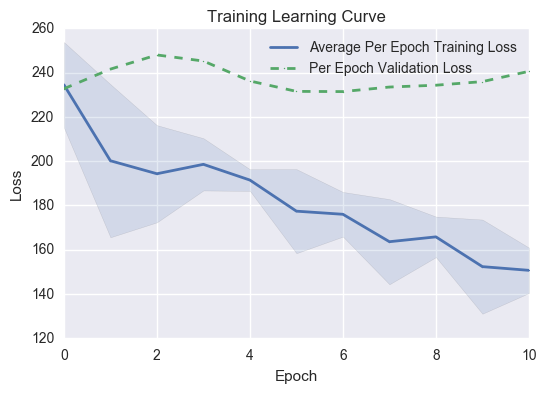

In [78]:
def plot_learning_curve(epoch_losses, valid_losses,
                        logx=False, 
                        logy=False,
                        title='Training Learning Curve',
                        xlabel='Epoch',
                        ylabel='Loss',
                        figsize=(6,4),
                        savename=None):
    fig, ax = plt.subplots(1, figsize=figsize)
    train_means = np.array([ np.mean(epoch_loss) for epoch_loss in epoch_losses ])
    train_stds = np.array([ np.std(epoch_loss) for epoch_loss in epoch_losses ])
    t = xrange(len(epoch_losses))
    ax.plot(t, train_means, 'bo-', lw=2,label='Average Per Epoch Training Loss', markersize=1)
    ax.fill_between(t, train_means+train_stds, train_means-train_stds, facecolor='b', alpha=0.15)
    ax.plot(range(len(valid_losses)), valid_losses, 'go--', lw=2, label='Per Epoch Validation Loss', markersize=1)
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    if savename:
        fig.savefig(savename)
    return fig, ax

plot_learning_curve(epoch_losses, valid_losses)

In [332]:
def predict(x_list, y_list, return_proba=False):
    # make a single batch out of the data
    x_iter = BucketedIterator(zip(x_list, y_list), len(x_list))
    x_list, y_list = zip(*x_iter.next())
        
    # run the model
    tagger.reset_state()
    logits_list, _ = tagger(sequence_converter(x_list)) 
    logits_list = [ logits.data for logits in logits_list ]
    
    if return_proba:
        probs = [ ch.functions.softmax(logit) for logit in logits_list ]
        probs = [ prob.data for prob in ch.functions.transpose_sequence(probs) ]
        return probs, x_list, y_list
    else:
        preds = [ ch.functions.argmax(logit, axis=1) for logit in logits_list ]
        preds = [ pred.data for pred in ch.functions.transpose_sequence(preds) ]
        return preds, x_list, y_list
    
def model_graph(x_list, out_fname):
    x_iter = BucketedIterator(x_list, len(x_list))
    x_list = x_iter.next()
        
    # run the model
    tagger.reset_state()
    logits_list = tagger(sequence_converter(x_list))
    g = ch.computational_graph.build_computational_graph(logits_list)
    with open(out_fname, 'w') as o:
        o.write(g.dump())
    print "Done.  Render {}".format(out_fname)

In [333]:
# print len(ix_test), len(ix_test[0])
# print len(preds[0]), len(ys[0])
# for a,b,c in zip(xs[-1], preds[-1], ys[-1]):
#     print a,b,c

In [334]:
def mode(L):
    """ Compute the mode of a list """
    types = {}
    for e in L:
        if e in types:
            types[e] += 1
        else:
            types[e] = 1
    return sorted(types.items(), reverse=True, key=lambda x:x[1])[0][0]

def extract_mentions(seq, typed=True):
    """ We extract mentions approximately according to the BIO or BILOU schemes
    with some relaxations.
    
    We start mentions when we see anything but an 'O'. 
    We end them when we see an 'O'.
    
    When computing the type of the mention
    we simply take the mode of the types of it's constituent tokens.
    """
    mentions = []
    in_mention = False
    mention_start = mention_end = 0
    for i, s in enumerate(seq):
        if not in_mention and s.startswith(('B', 'I', 'L', 'U')):
            mention_start = i
            in_mention = True
        elif in_mention and s == 'O':
            if typed:
                mention_type = mode([ s.split('-')[-1] for s in seq[mention_start:i] ])
            else:
                mention_type = 'E'
            mentions.append((mention_start, i-1, mention_type))
            in_mention=False
    if in_mention: # we end on a mention
        if typed:
            mention_type = mode([ s.split('-')[-1] for s in seq[mention_start:i] ])
        else:
            mention_type = 'E'
        mentions.append((mention_start, i, mention_type))
    return mentions
    
def extract_all_mentions(seqs, typed=True):
    return [extract_mentions(seq, typed=typed) for seq in seqs]

def mention_precision_recall(true_mentions, pred_mentions):
    """ This function returns the counts of true positives, false positives, and false negatives
    which are necessary for calculating precision and recall.
    A mention boundary is considered correct if both ends are correct. 
    """
    true_mentions = set(true_mentions)
    pred_mentions = set(pred_mentions)
    tp = len(true_mentions & pred_mentions)
    fn = len(true_mentions - pred_mentions)
    fp = len(pred_mentions - true_mentions)
    return tp, fp, fn

def mention_boundary_stats(true_ys, pred_ys, typed=True):
    all_true_mentions = extract_all_mentions(true_ys, typed=typed)
    all_pred_mentions = extract_all_mentions(pred_ys, typed=typed)
    stats = {'tp':0,
             'fp':0,
             'fn':0}
    for true_mentions, pred_mentions in zip(all_true_mentions, all_pred_mentions):
        tp, fp, fn = mention_precision_recall(true_mentions, pred_mentions)
        stats['tp'] += tp
        stats['fp'] += fp
        stats['fn'] += fn
    stats['precision'] = tp / float(tp + fp +1e-15)
    stats['recall'] = tp / float(tp + fn +1e-15)
    stats['f1'] = 2*stats['precision']*stats['recall']/(stats['precision']+stats['recall']+1e-15)
    return stats

In [336]:
for a,b,c in zip(xs[-1], preds[-1], ys[-1]):
    print a,b,c

< B O
DOC I O
> B O
< B O
DOCID O O
> O O
<UNK> O O
< B O
/DOCID I O
> B O
< B O
DOCTYPE B O
SOURCE="broadcast <UNK> O
news I O
" I O
> B O
NEWS <UNK> O
STORY <UNK> O
< B O
/DOCTYPE B O
> B O
< B O
DATETIME B O
> B O
2003 B O
- <UNK> O
04 I O
- <UNK> O
09 <UNK> O
<UNK> O O
< B O
/DATETIME O O
> B O
< B O
BODY O O
> B O
< B O
TEXT I O
> B O
< B O
TURN O O
> B O
a <UNK> O
federal <UNK> O
appeals <UNK> O
court <UNK> B
will O O
decide I O
how I O
long <UNK> O
dirty <UNK> O
bomb <UNK> B
suspect I B
<UNK> O B
<UNK> O I
can I O
be <PAD> O
<UNK> O O
and O O
whether I O
he <PAD> B
can B O
meet B O
with B O
attorneys B B
. B O
the B O
u.s B B
. O O
attorney I B
says O O
<UNK> O B
is O O
an <PAD> O
enemy <UNK> O
<UNK> O B
and O O
not O O
<UNK> O O
to O O
<UNK> O O
. I O
he <PAD> B
is <PAD> O
accused <UNK> O
of B O
<UNK> <PAD> O
to I O
<UNK> <PAD> O
a <UNK> O
dirty <UNK> O
bomb <UNK> B
in B O
this <PAD> O
country O B
. O O
< B O
/TURN B O
> B O
< B O
/TEXT <UNK> O
> B O
< B O
/BODY O O
> O O
< B O

# Chainer Trainer Abstraction

In [51]:
# embed = ch.functions.EmbedID(token_vocab.v, 100)
# tagger = Tagger(embed, 100, boundary_vocab.v)
# model_loss = SequenceLoss(tagger)
# optimizer = ch.optimizers.Adam()
# optimizer.use_cleargrads()
# optimizer.setup(model_loss)

# train_iter = BucketedIterator(zip(ix_train, iy_train), 64, repeat=True)
# valid_iter = BucketedIterator(zip(ix_valid, iy_valid), 64, repeat=True)
# updater = SequenceUpdater(train_iter, optimizer)
# trainer = ch.training.Trainer(updater, (10, 'epoch'), out='result')
# trainer.extend(ch.training.extensions.ProgressBar(update_interval=5))
# trainer.extend(SequenceEvaluator(valid_iter, model_loss))
# # trainer.extend(PrintReport())

# trainer.run()

     total [..................................................]  0.00%
this epoch [..................................................]  0.00%
         5 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.


KeyboardInterrupt: 

In [150]:
print npr.shuffle([1,2,3])

None


In [74]:
'abc'

1453079729188098211

In [206]:
    
def sequence_converter(in_list, device=None):
    # note that device is omitted
    return ch.functions.transpose_sequence([ ch.Variable(np.array(x, dtype=np.int32))
                                             for x in in_list ])
def volatile_sequence_converter(in_list, device=None):
    # note that device is omitted
    return ch.functions.transpose_sequence([ ch.Variable(np.array(x, dtype=np.int32),
                                                         volatile="AUTO")
                                             for x in in_list ])
    
class SequenceUpdater(ch.training.StandardUpdater):
    def __init__(self, *args, **kwds):
        super(SequenceUpdater, self).__init__(*args, **kwds)
        self.converter = sequence_converter
        
    def update_core(self):
        batch = self._iterators['main'].next()        

        optimizer = self._optimizers['main']
        loss_func = self.loss_func or optimizer.target

        if isinstance(batch, tuple):
            in_vars = tuple([self.converter(x_list) for x_list in zip(*batch)])
            optimizer.update(loss_func, *in_vars)
        elif isinstance(batch, dict):
            in_vars = {key: self.converter(x_list)
                       for key, x_list in six.iteritems(batch)}
            optimizer.update(loss_func, **in_vars)
        else:
            in_var = self.converter(batch)
            optimizer.update(loss_func, in_var)
            
import chainer.reporter as reporter_module
class SequenceEvaluator(ch.training.extensions.Evaluator):
    def __init__(self, *args, **kwds):
        super(SequenceEvaluator, self).__init__(*args, **kwds)
        self.converter = volatile_sequence_converter
        
    def evaluate(self):
        """Evaluates the model and returns a result dictionary.

        This method runs the evaluation loop over the validation dataset. It
        accumulates the reported values to :class:`~chainer.DictSummary` and
        returns a dictionary whose values are means computed by the summary.

        Users can override this method to customize the evaluation routine.

        Returns:
            dict: Result dictionary. This dictionary is further reported via
                :func:`~chainer.report` without specifying any observer.

        """
        iterator = self._iterators['main']
        target = self._targets['main']
        eval_func = self.eval_func or target

        if self.eval_hook:
            self.eval_hook(self)
        it = copy.copy(iterator)
        summary = reporter_module.DictSummary()

        for batch in it:
            observation = {}
            with reporter_module.report_scope(observation):
                if isinstance(batch, tuple):
                    in_vars = tuple([self.converter(x_list) for x_list in zip(*batch)])
                    eval_func(*in_vars)
                elif isinstance(batch, dict):
                    in_vars = {key: self.converter(x_list)
                               for key, x_list in six.iteritems(batch)}
                    eval_func(**in_vars)
                else:
                    in_var = self.converter(batch)
                    eval_func(in_var)
            summary.add(observation)

        return summary.compute_mean()

IndentationError: expected an indented block (<ipython-input-206-bcff80e9d78d>, line 4)

In [4]:
import chainer as ch
embed = ch.links.EmbedID(2,2)
class Embed(ch.Chain):
    def __init__(self, embed):
        super(Embed, self).__init__(
            embed_name = embed
        )
    def __call__(self, x):
        return self.embed(x)
    
e1 = Embed(embed)
e2 = Embed(embed.copy())

In [7]:
raise NotImplementedError

NotImplementedError: 

In [4]:
'B'.startswith(('O', 'S'))

False

In [6]:
'B'.split('-')[1]

IndexError: list index out of range

In [7]:
sorted([3,2,1])

[1, 2, 3]